# Bean Disease Classification using MobileNet_V3

IMPORTING LIBRARIES AND DEPENDENCIES

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import os
import numpy as np

import tensorflow_datasets as tfds
import warnings
warnings.filterwarnings('ignore')

Loading Data

In [3]:
datasets, info=tfds.load(name='beans', with_info=True, as_supervised=True, split=['train','test','validation'])

In [4]:
info

tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.1.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
    by experts from the National Crops Resources Research Institute (NaCRRI) in
    Uganda and collected by the Makerere AI research lab.
    """,
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    data_path='C:\\Users\\user\\tensorflow_datasets\\beans\\0.1.0',
    file_format=tfrecord,
    download_size=171.69 MiB,
    dataset_size=171.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=128, num_shards=1>,
   

Data Visualization

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


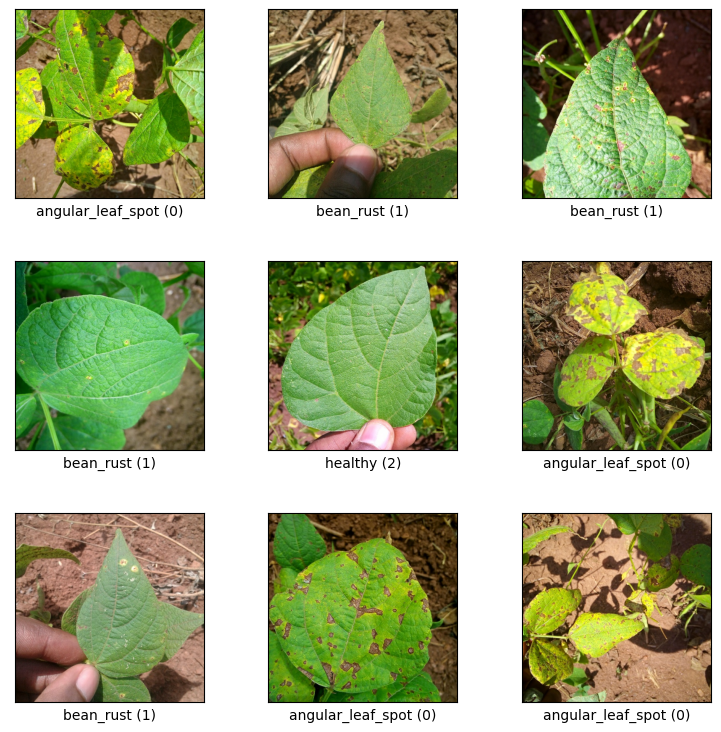

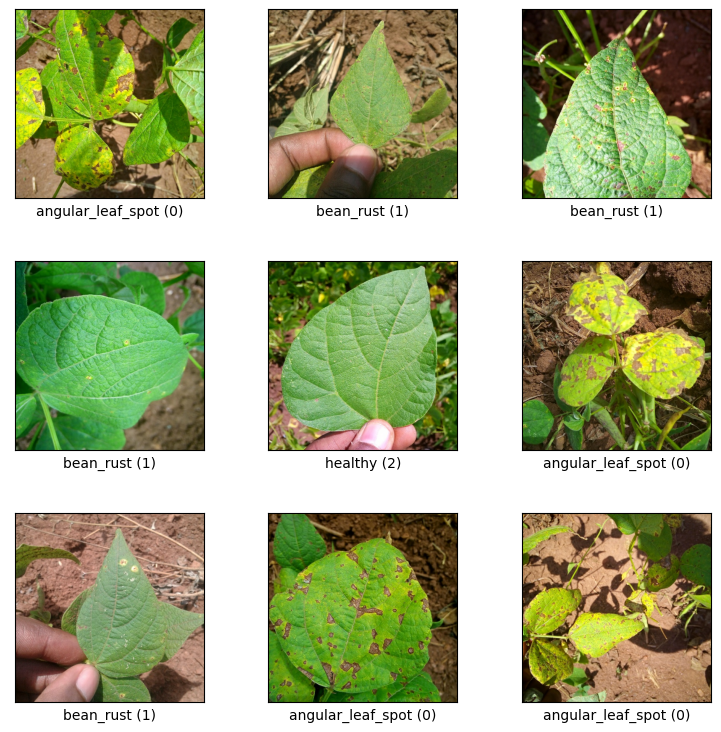

In [5]:
train, info_train=tfds.load(name='beans',with_info=True, split='test')
tfds.show_examples(info_train,train)

In [6]:
def scale(image, lable):
  image = tf.cast(image, tf.float32)
  image/=255
  return tf.image.resize(image, [224,224]), tf.one_hot(lable, 3)

In [7]:
def get_dataset(batch_size=32):
  train_dataset_scaled=datasets[0].map(scale).shuffle(1000).batch(batch_size)
  test_dataset_scaled=datasets[1].map(scale).batch(batch_size)
  val_dataset_scaled=datasets[2].map(scale).batch(batch_size)
  return train_dataset_scaled, test_dataset_scaled, val_dataset_scaled

In [8]:
train_dataset, test_dataset, val_dataset = get_dataset()
train_dataset.cache()
val_dataset.cache()

<CacheDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [12]:
len(list(datasets[0]))

1034

In [9]:
# featutre_extractor="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [10]:
featutre_extractor = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5"

In [11]:
featutre_extractor_layer=hub.KerasLayer(featutre_extractor, input_shape=(224,224,3))

In [12]:
featutre_extractor_layer.trainable=False

In [13]:
from keras import layers
from keras import models

In [14]:
model = models.Sequential([featutre_extractor_layer])
model.add(layers.Flatten())
model.add(layers.Dense(1280, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(3, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              4226432   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1280)              1639680   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 5,869,955
Trainable params: 1,643,523
Non-trainable params: 4,226,432
_________________________________________________________________


In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['acc'])

In [17]:
class CollectBatchStat(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses=[]
        self.batch_acc=[]
    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()
batch_stats_callback = CollectBatchStat()

In [18]:
history=model.fit_generator(train_dataset, epochs=5, validation_data=val_dataset,callbacks=[batch_stats_callback])

Epoch 1/5
33/33 [==============================] - 57s 1s/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.1837 - val_acc: 0.9323
Epoch 2/5
33/33 [==============================] - 45s 1s/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.1702 - val_acc: 0.9248
Epoch 3/5
33/33 [==============================] - 54s 1s/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.1513 - val_acc: 0.9549
Epoch 4/5
33/33 [==============================] - 54s 1s/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.1566 - val_acc: 0.9323
Epoch 5/5
33/33 [==============================] - 49s 1s/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.1364 - val_acc: 0.9398


In [19]:
result=model.evaluate(test_dataset)

4/4 [==============================] - 5s 1s/step - loss: 0.1322 - acc: 0.9453


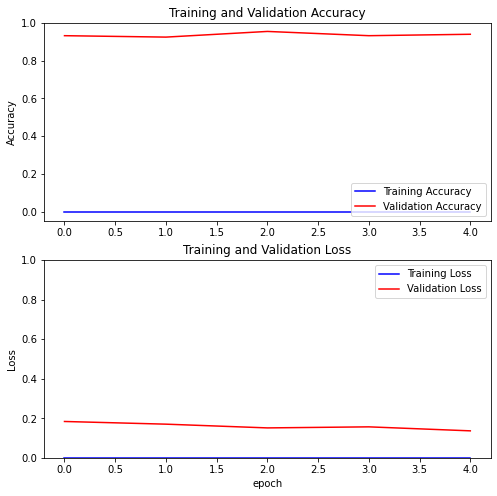

In [24]:
acc=history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color = 'blue')
plt.plot(val_acc, label='Validation Accuracy', color = 'red')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss',color='red')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()